In [4]:
planta=eval(input('Planta a Analizar '))

Planta a Analizar 7


In [5]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import acf
import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from numpy import inf

from IPython.display import display, HTML
display(HTML(""" <style> .output {display: center; align-items: left; text-align: center; justify-content: center; } </style> """))

In [6]:
#Importación de datos
datos = pd.read_excel('Generación Intermitente de la GCROC 2013-2020.xlsx', header=1)

In [7]:
numbers = datos.hora-1
hours = [datetime.time(num).strftime("%H:00:00") for num in numbers]
datos['fecha'] = datos['fecha'].replace(0,np.nan).ffill()
datos['fecha'] = pd.to_datetime(datos['fecha'])
datos['fecha'] = datos['fecha'].dt.date
datos['fecha_hora'] = datos["fecha"].astype(str) + ' ' + hours
#LIMPIEZA DE DATOS
datos = datos.set_index(datos['fecha_hora'])
datos = datos[53736:]

In [8]:
columns = ['GICIE301', 'GICIE302','GICIE303','GICIE304','GICIE305','GICIS306', 'GICIS307','GICIS308',
          'GICIS309','GICIS310','GICIS311','GICIS312','GICIS313','GICIS314','GICIS315','GICIS316','GICIS317',
          'GICIS318','GICIS319','GICIS320','GICIS321','GICIS322','GICIS323','GICIS324','GICIS325','GICIS326']

In [9]:
n_periods = 5*24
columna = columns[planta-1]
columna

'GICIS307'

In [10]:
df = datos[['hora',columna]]
df[columna] = (df[columna]) # para efectos de las tranformaciones logaritmicas(eliminar el 0)
df = df.dropna()
df.head()

,hora,GICIS307
fecha_hora,,
2020-01-01 00:00:00,1,0.0
2020-01-01 01:00:00,2,0.0
2020-01-01 02:00:00,3,0.0
2020-01-01 03:00:00,4,0.0
2020-01-01 04:00:00,5,0.0


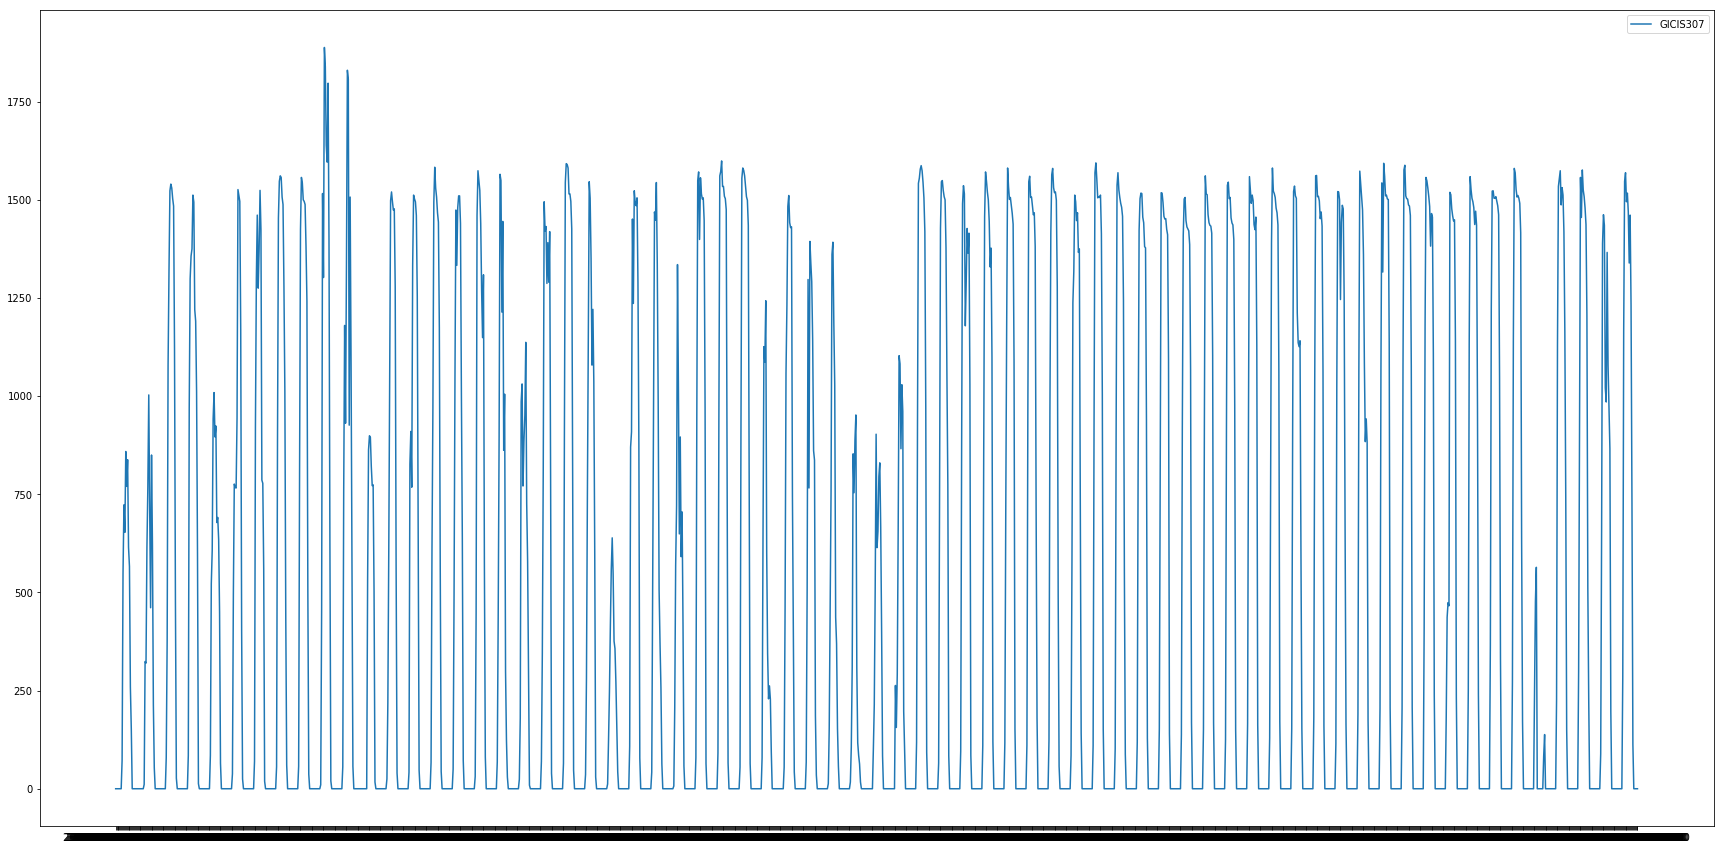

In [11]:
plt.figure(figsize=(30,15))
graph=df[df.columns[1]]
plt.plot(graph,label=columna)
plt.legend(loc='best')
plt.show()

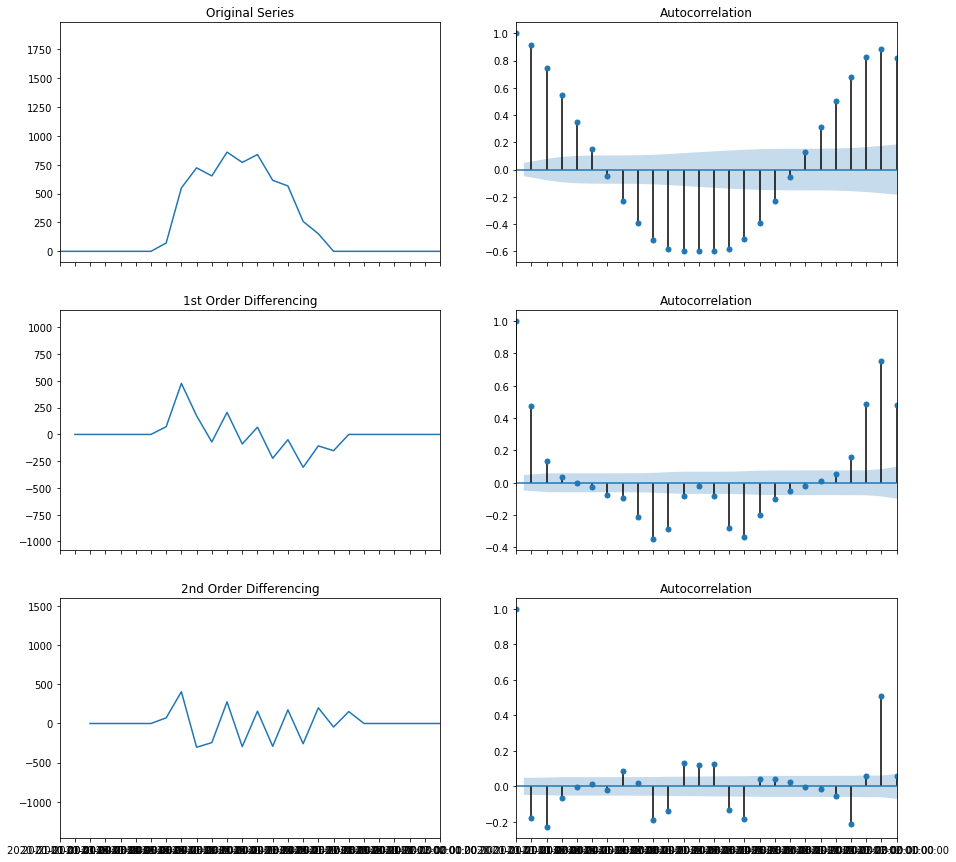

In [12]:
# Original Series
df2 = df.drop(['hora'], axis=1)
df2

fig, axes = plt.subplots(3, 2, sharex=True,figsize=(15,15))
axes[1,0].set_xlim([0, 100])
axes[0,1].set_xlim([0, 25])
axes[0, 0].plot(df2); axes[0, 0].set_title('Original Series')
plot_acf(df2, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df2.diff()); axes[1, 0].set_title('1st Order Differencing')
axes[0,0].set_xlim([0, 25])
plot_acf(df2.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df2.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
axes[0,0].set_xlim([0, 25])
plot_acf(df2.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

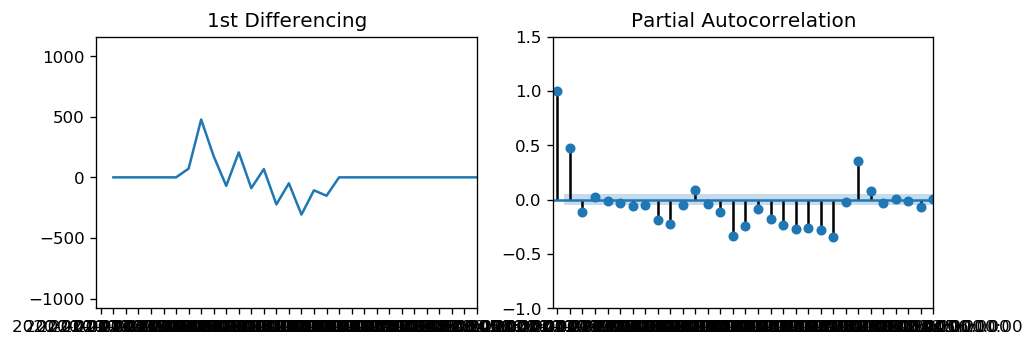

In [13]:
#How to find the order of the AR term (p)
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].set_xlim([0, 25])
axes[1].set(ylim=(-500,600))
axes[0].plot(df2.diff()); axes[0].set_title('1st Differencing')
axes[1].set_xlim([-0.35, 30])
axes[1].set(ylim=(-1,1.5))
plot_pacf(df2.diff().dropna(), ax=axes[1])

plt.show()

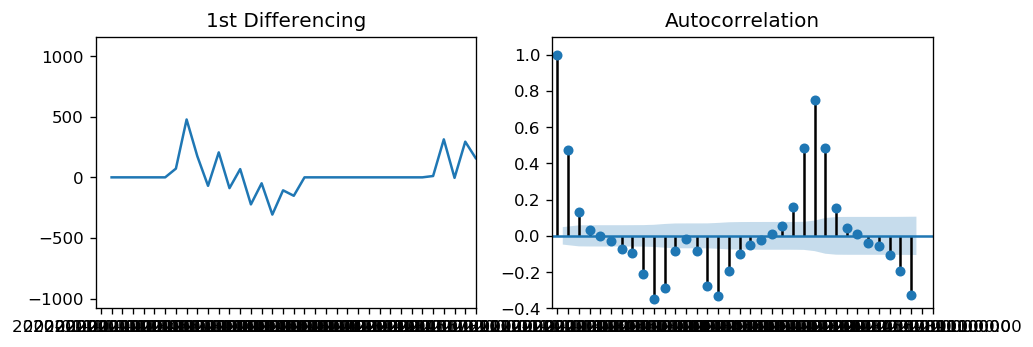

In [14]:
#%%How to find the order of the MA term (q)
import pandas as pd
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df2.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(-0.40,1.10))
axes[1].set(xlim=(-0.5,35))
plot_acf(df2.diff().dropna(), ax=axes[1])

plt.show()

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

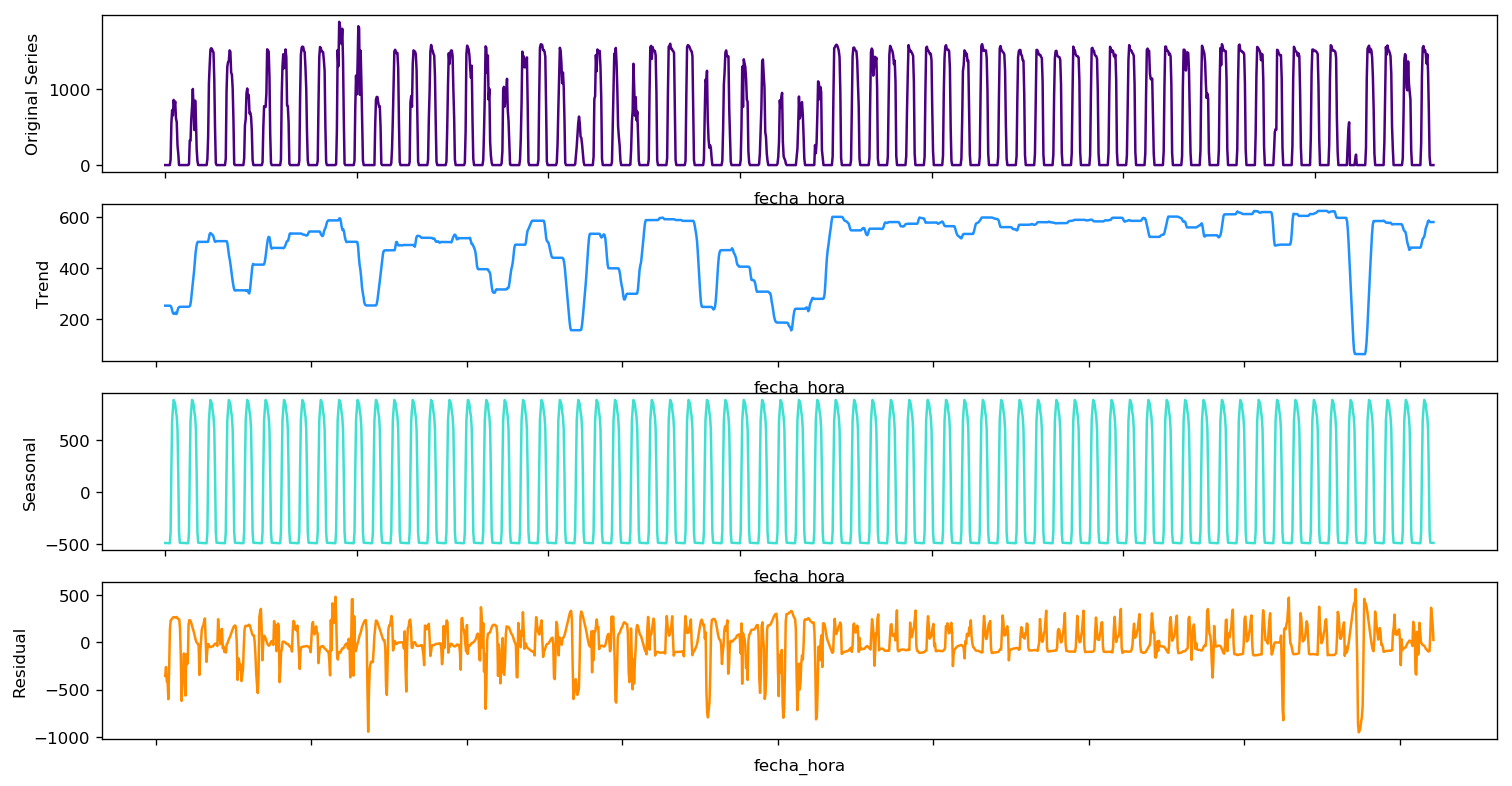

In [56]:
import matplotlib.pyplot as plt 

result = seasonal_decompose(df2, model='additive',freq=24)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(15,8))

ax1.set_ylabel('Original Series')
ax2.set_ylabel('Trend')
ax3.set_ylabel('Seasonal')
ax4.set_ylabel('Residual')

result.observed.plot(ax=ax1,color='indigo')
result.trend.plot(ax=ax2,color='dodgerblue')
result.seasonal.plot(ax=ax3,color ='turquoise')
result.resid.plot(ax=ax4,color='darkorange')

In [22]:
# Test for stationarity

from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(df2.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


ADF Statistic: -5.624148800656322
p-value: 1.12739428768414e-06
Critial Values:
   1%, -3.4343681767217062
Critial Values:
   5%, -2.863314793016078
Critial Values:
   10%, -2.5677148609281493

KPSS Statistic: 1.025266
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


In [60]:

# KPSS Test
result = kpss(df2.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 1.025266
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739
